# CSCI 4022 Final Project Data Preprocessing and Exploration



In [4]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn.mixture import GaussianMixture

## Data Preprocessing

### Team data preprocessing

To cluster teams, I need to have one data point for each team. The problem is that I currently have lots of data points for each team due to having box scores for multiple games per team. In order to solve this problem and prepare the data for clustering, I will get the average box score for each team and store it in a new dataset that will be used for clustering.

In [5]:
dfTeamBox = pd.read_csv('team_box_scores_clean.csv')

In [6]:
dfTeamBox.select_dtypes(exclude=['int', 'float']).columns

Index(['game_id', 'home_team', 'team_id', 'conf_id', 'opp_id', 'opp_conf_id',
       'win'],
      dtype='object')

Since I will be averaging the box scores, I need to get rid of the non-numerical data. I will group by the team_id so it can stay. The win column could be converted to two numerical columns via one hot encoding. The rest of the columns can be dropped along with season because it is categorical despite being a numerical type.

In [7]:
dfTeamBox.drop(['game_id', 'home_team', 'season', 'conf_id', 'opp_id', 'opp_conf_id'], axis=1, inplace=True)
columns_to_enode = ['win']
dfTeamBoxEncoded = pd.get_dummies(dfTeamBox, columns=columns_to_enode)

In [8]:
dfTeamStatsUN = dfTeamBoxEncoded.groupby('team_id').mean()

In [9]:
scaler = StandardScaler()
dfTeamStats = pd.DataFrame(scaler.fit_transform(dfTeamStatsUN), columns=dfTeamStatsUN.columns)
dfTeamStats

,attendance,lead_changes,times_tied,periods,venue_capacity,points_game,minutes,field_goals_made,field_goals_att,field_goals_pct,...,opp_blocks,opp_assists_turnover_ratio,opp_personal_fouls,opp_fast_break_pts,opp_second_chance_pts,opp_points_off_turnovers,opp_flagrant_fouls,opp_player_tech_fouls,win_False,win_True
0,-0.866891,0.896464,-0.135246,-0.437086,-0.915901,-1.123332,-0.436176,-0.621068,0.619155,-1.404280,...,0.912424,0.796857,-1.585045,0.321013,0.958604,2.602678,-0.733060,-1.276822,2.219338,-2.219338
1,-0.869444,1.649227,1.629362,0.647256,-1.183325,0.793725,0.649828,0.768217,1.133444,-0.020866,...,-0.601774,-0.889019,-0.420291,1.489720,0.393618,0.213081,-0.733060,-0.400823,-0.272180,0.272180
2,0.048605,-1.396287,-1.214094,0.419925,0.239139,-0.953993,0.422149,-0.991112,-1.096602,-0.382845,...,0.652237,2.215028,0.185985,1.486064,0.380053,0.968593,2.237636,0.470049,-0.045357,0.045357
3,0.024847,-0.051633,-0.029112,-0.558586,0.399867,-0.190054,-0.557863,0.137747,-0.885014,1.002132,...,-2.198662,0.029741,0.289113,-1.003229,0.100846,-0.480392,-0.020093,-0.665088,-0.144280,0.144280
4,1.921320,-1.566769,-1.124539,1.114213,2.143559,1.133534,1.117500,1.107163,0.120908,1.289300,...,0.025148,0.836546,0.053579,2.739136,-0.267776,0.670629,0.397254,0.608481,-0.432494,0.432494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,-0.581803,0.358322,0.340618,-0.669781,-0.058581,0.259517,-0.669228,-0.118932,0.107758,-0.280062,...,-0.043481,0.179472,0.732909,0.839566,0.762000,0.522424,-0.733060,-0.205627,0.260404,-0.260404
347,-0.796225,1.002929,0.152427,-1.041488,-0.229927,-0.341089,-1.041504,-0.428821,-0.933646,0.169837,...,-1.546086,-1.174263,1.307477,-0.135819,0.449985,0.459293,-0.365259,0.547270,-0.480018,0.480018
348,-0.482229,-0.070764,-0.781654,1.161222,-0.680430,0.311886,1.164581,0.121310,-0.768405,0.912974,...,-0.326922,-0.913398,-0.993995,-1.632614,-2.248852,-1.381227,-0.336967,-1.421845,-0.899690,0.899690
349,-0.404245,0.523050,0.655539,-0.328110,-0.491430,0.546868,-0.327034,0.564251,0.706899,0.084731,...,0.230589,2.474038,-0.327019,2.329363,0.380603,0.532468,0.320187,-0.045922,0.547362,-0.547362


In [24]:
dfTeamStats.index = dfTeamStatsUN.index
dfTeamStats.to_csv('team_stats.csv', index=True)
dfTeamStats = dfTeamStats.reset_index(drop=True)

## Feature Selection

Look at the correlation between features and git rid of highly correlated features.

In [27]:
# reogranize a dataframe putting correlated columns next to each other
def reorgByCorr(df):
    corr_matrix = df.corr().abs()  
    new_col_order = []
    new_col_order.append(corr_matrix.index[0])

    while len(new_col_order) < len(df.columns):
        prev_col = new_col_order[-1]
        max_corr = 0
        max_corr_col = None
        for column in df.columns:
            if column not in new_col_order:
                corr = corr_matrix.loc[prev_col, column]
                if corr > max_corr:
                    max_corr = corr
                    max_corr_col = column
        new_col_order.append(max_corr_col)
        
    return df[new_col_order]

def plotCorrHeatmap(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Matrix Heatmap')
    plt.show()

In [28]:
dfTeamStatsFS = reorgByCorr(dfTeamStats).copy()
dfTeamStatsFS.columns

Index(['attendance', 'venue_capacity', 'opp_blocked_att', 'blocked_att',
       'opp_flagrant_fouls', 'two_points_pct', 'field_goals_pct',
       'three_points_pct', 'three_points_made', 'three_points_att',
       'two_points_att', 'two_points_made', 'field_goals_made', 'points_game',
       'assists', 'assists_turnover_ratio', 'turnovers',
       'opp_points_off_turnovers', 'opp_steals', 'opp_points_game',
       'opp_field_goals_made', 'opp_two_points_made', 'opp_two_points_att',
       'opp_field_goals_att', 'opp_second_chance_pts',
       'opp_offensive_rebounds', 'opp_rebounds', 'opp_defensive_rebounds',
       'win_False', 'win_True', 'opp_field_goals_pct', 'opp_three_points_pct',
       'opp_assists', 'opp_assists_turnover_ratio', 'points_off_turnovers',
       'opp_turnovers', 'steals', 'fast_break_pts', 'opp_fast_break_pts',
       'field_goals_att', 'second_chance_pts', 'offensive_rebounds',
       'rebounds', 'defensive_rebounds', 'blocks', 'flagrant_fouls',
       'lead_cha

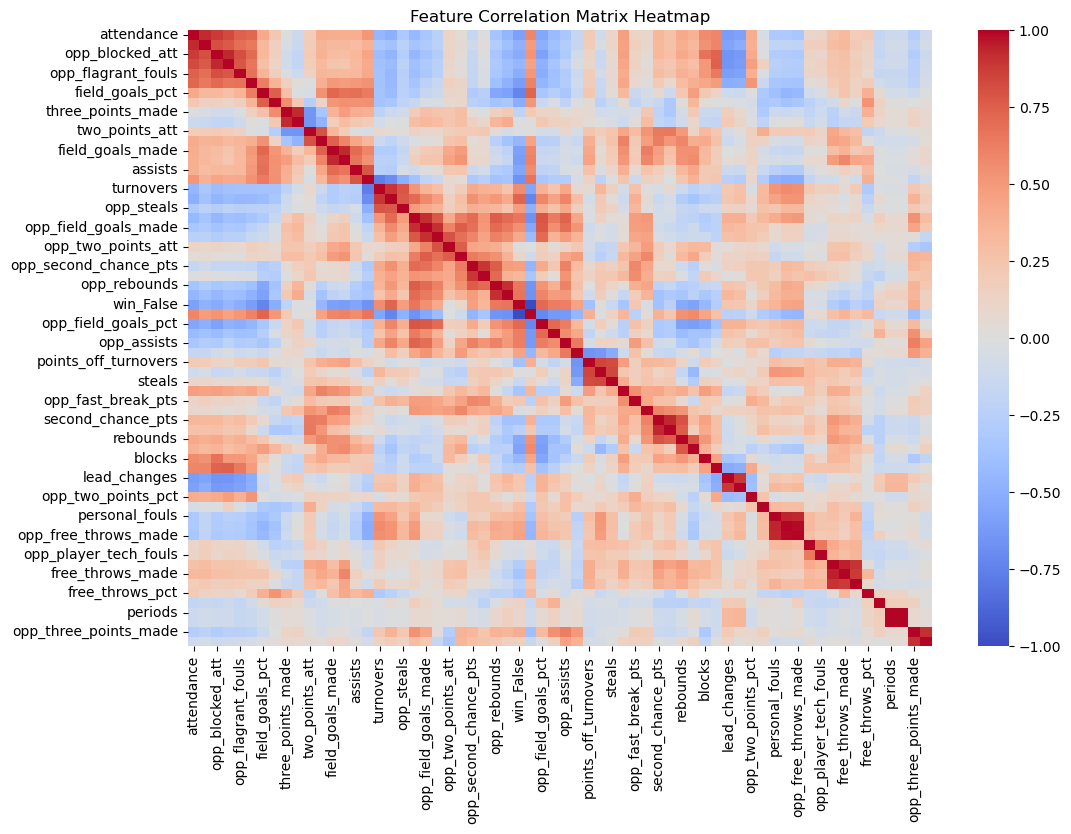

In [29]:
plotCorrHeatmap(dfTeamStatsFS)

Removing highly correlated columns:
- Remove times tied as it is highly correlated with lead changes
- Remove venue capacity as it is highly correlated with attendance
- Remove periods as it is highly correlated with minutes
- Remove win false as it is negatively correlated with win true
- Keep rebounds but remove offensive and defensive rebounds
- Keep three points made and remove three points attempted and percentage (same for two points)
- Remove free throws attempted and percentage as they are correalted with free throws made
- Remove field goals attempted, made, and percentage as they correlate with points 

In [30]:
dfTeamStatsFS.drop(['venue_capacity', 'opp_blocked_att', 'blocked_att', 'opp_flagrant_fouls', 
                  'two_points_pct', 'three_points_pct', 'three_points_att','two_points_att', 
                  'field_goals_made', 'assists', 'opp_points_off_turnovers', 'opp_steals', 
                  'opp_field_goals_made', 'opp_two_points_att', 'opp_field_goals_att', 
                  'opp_second_chance_pts', 'opp_defensive_rebounds', 'win_False', 
                  'opp_three_points_pct', 'opp_assists', 'points_off_turnovers', 'steals', 
                  'field_goals_att', 'second_chance_pts', 
                  'defensive_rebounds', 'flagrant_fouls', 'times_tied', 
                  'opp_two_points_pct', 'personal_fouls', 'opp_free_throws_att', 
                  'player_tech_fouls', 'opp_player_tech_fouls', 'free_throws_att', 'opp_personal_fouls', 
                  'free_throws_pct', 'opp_free_throws_pct', 'periods', 'opp_three_points_att',
                   'turnovers', 'opp_turnovers', 'opp_field_goals_pct', 'offensive_rebounds',
                   'opp_offensive_rebounds', 'points_game', 'opp_points_game', 'opp_rebounds'], axis=1, inplace=True)

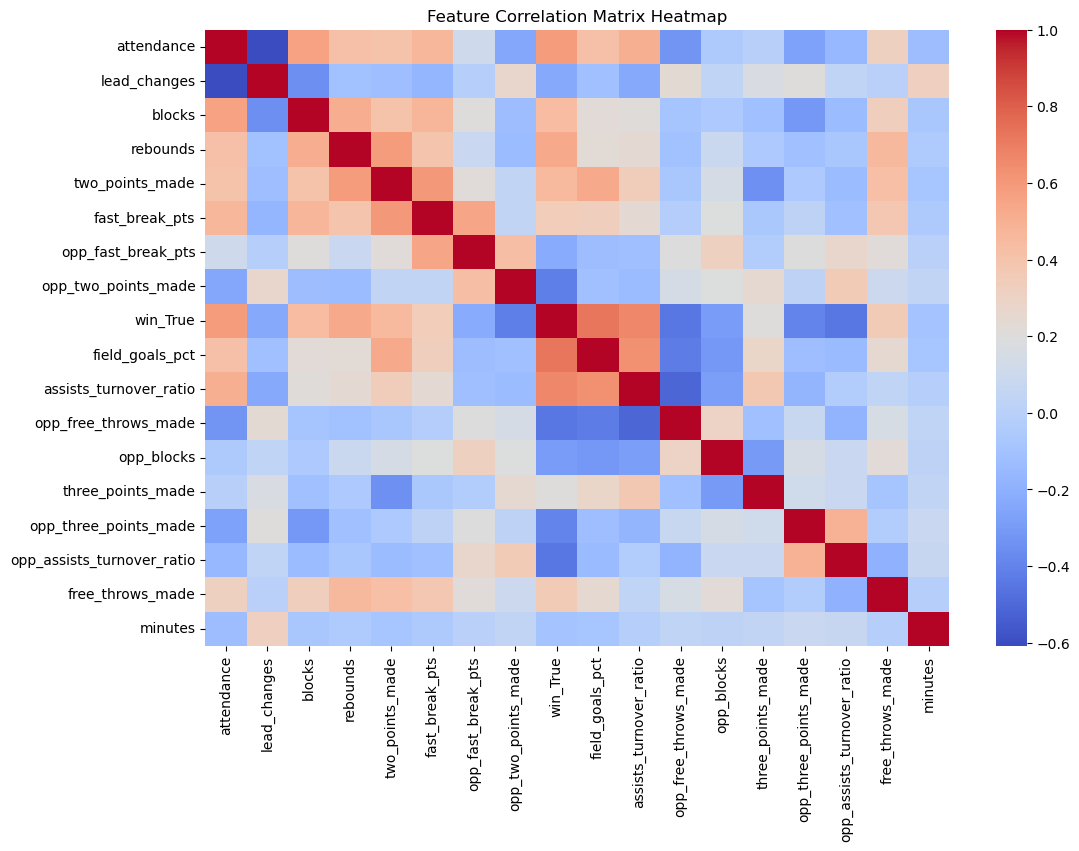

In [31]:
plotCorrHeatmap(reorgByCorr(dfTeamStatsFS))

## Principal Component Analysis

Now that I have a reduced dataset that has limited correlated columns, I want to conduct PCA on the dataset. I want to reduce the dataset to 3 principal components. This will make visualizing and comparing clusters easier and I will sacrifice the benefit of more columns for the interpretability of only using three principal components.

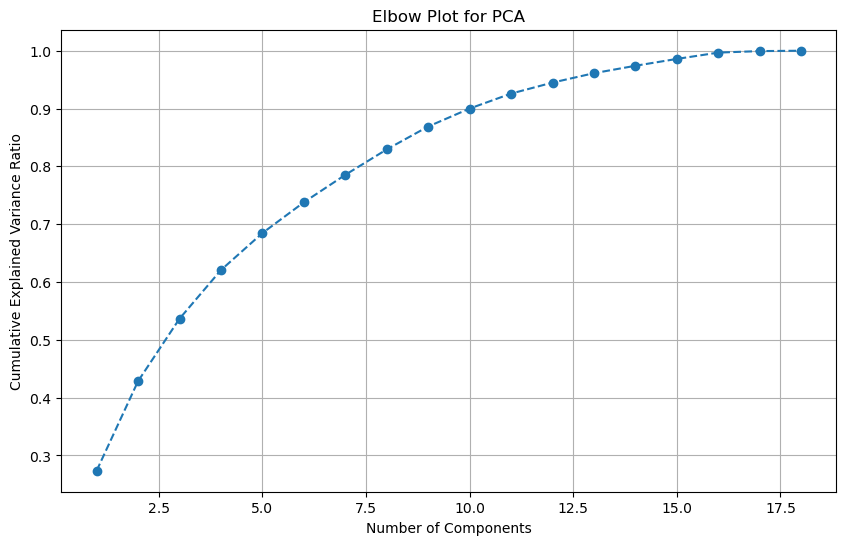

In [37]:
# conduct pca and make a plot of how much of the variance each principal component explains
pca = PCA()
pca.fit(dfTeamStatsFS)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()

Three principal components explains around 55% of the overall variance. While this is not an overwhelming amount, I will sacrifice explaining more variance for interpretability.

In [38]:
# reduce dataset to three principal components
n_components=3
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(dfTeamStatsFS)
columns = [f"PC{i+1}" for i in range(n_components)]
dfTeamStatsPCA = pd.DataFrame(data=principal_components, columns=columns)
dfTeamStatsPCA.to_csv('team_stats_pca.csv', index=False)
dfTeamStatswPCA = pd.concat([dfTeamStatsPCA, dfTeamStatsFS], axis=1)

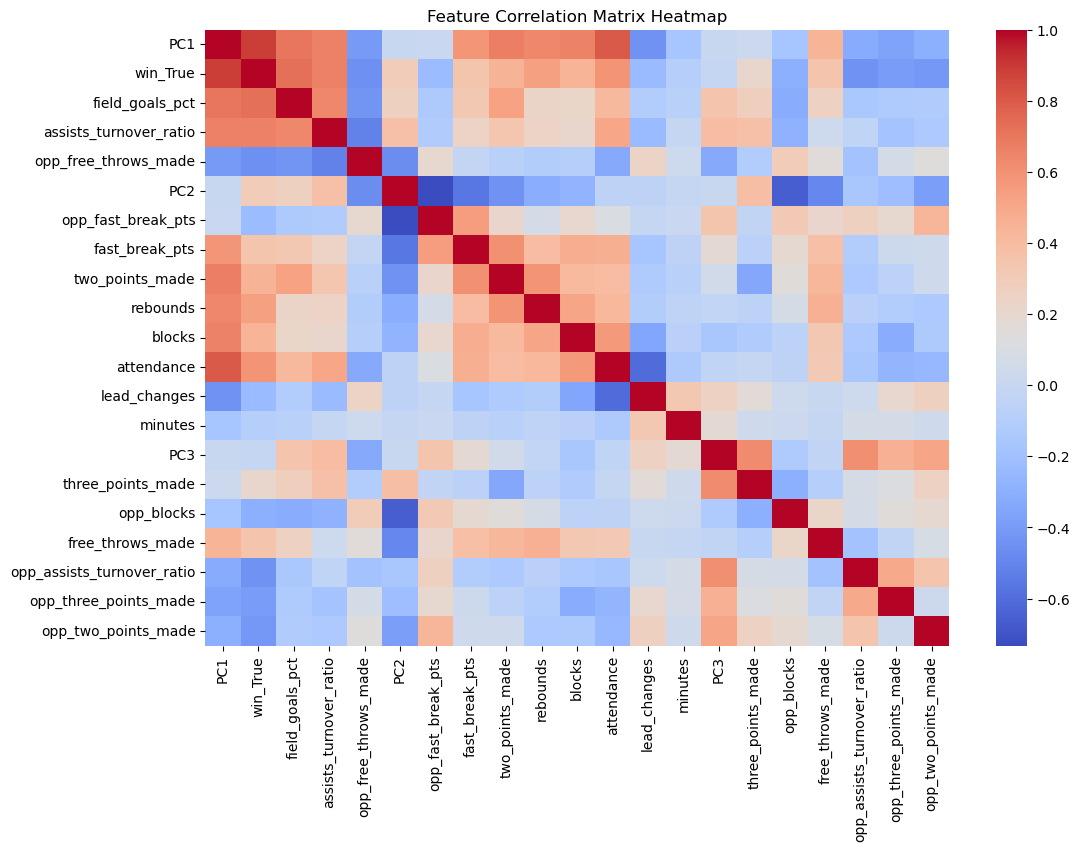

In [39]:
# plot correlation heatmap with principal components added
plotCorrHeatmap(reorgByCorr(dfTeamStatswPCA))

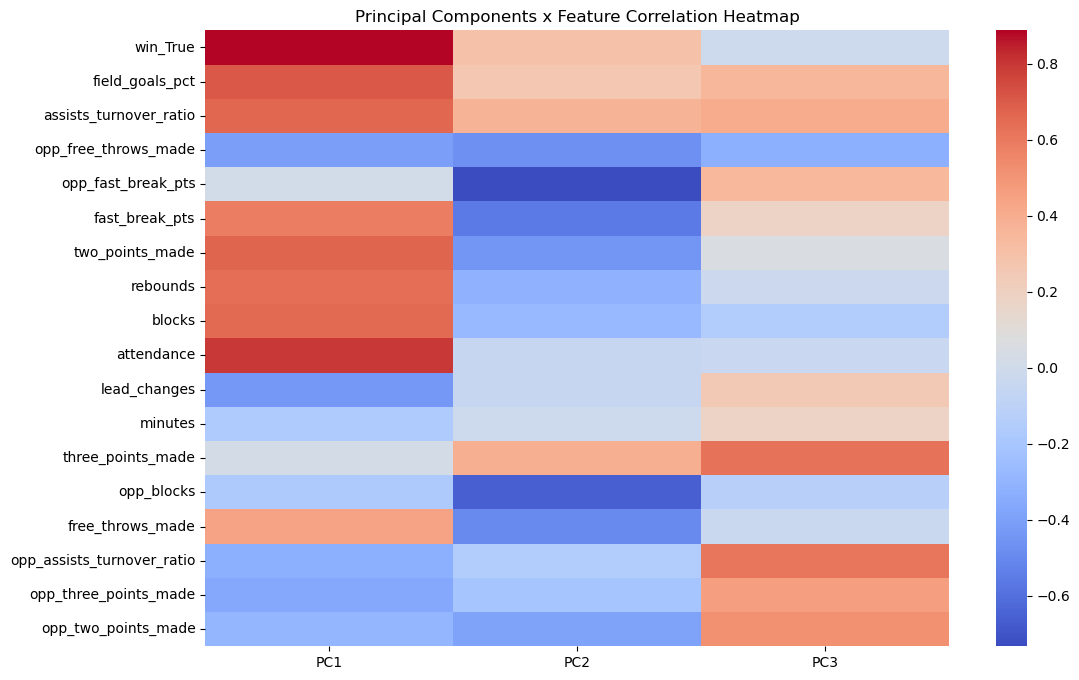

In [52]:
# zoom in on just principal component comparison
corr_matrix = reorgByCorr(dfTeamStatswPCA).corr()[['PC1', 'PC2', 'PC3']].drop(['PC1', 'PC2', 'PC3'])
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Principal Components x Feature Correlation Heatmap')
plt.show()

PC1
- Team is playing well
- Large positive correlation with good stats
- Slightly negative correlation with bad stats

PC2
- Small positive correlation with good stats
- Large negative correlation with bad stats

PC3
- High positive correlation with making threes